# Evaluation

In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
from datasets import load_data
from plots import visualize_batch, save_image
from datasets import rescaling_inv 
from configs.ddpm import mnist as configs 

## settings
config = configs.get_config()

# manually changed some settings for quick testing 
workdir='./results/ddpm_mnist'
config.training.batch_size = 25
distributed=False 
device = config.device 

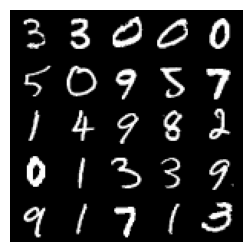

In [2]:
train_loader, test_loader, _ = load_data(config=config, data_path="../datasets", num_workers=3, evaluation=True, distributed=False)
x, _ = next(iter(train_loader))

dataset_name = config.data.dataset
visualize_batch(rescaling_inv(x[:25]), nrow=5, figsize=(3,5))

### Load train model

In [4]:
# Load model and set diffusion class

from models.ddpm import DDPM
from diffusion.losses import get_model_fn
from diffusion.diffusion_lb import GaussianDiffusion

model = DDPM(config)
get_model_fn(model, train=False) 

checkpoint_dir = os.path.join(workdir, "model")
ckpt = config.eval.checkpoint
ckpt_dir = os.path.join(checkpoint_dir, "ckpt_{}_checkpoint.pt".format(ckpt))
loaded_state = torch.load(ckpt_dir, map_location=device)
model.load_state_dict(loaded_state['net']) 
model.to(config.device)
print()

In [5]:
diffusion = GaussianDiffusion(config.model.beta_min, config.model.beta_max, T=1000)  # defines the diffusion process

### Generate samples

In [6]:
import diffusion.sampling as sampling 

sampler_method = sampling.get_sampler(config.sampling.sampler.lower())
sampler = sampler_method(diffusion, model)

100%|██████████| 1000/1000 [00:26<00:00, 37.27it/s]


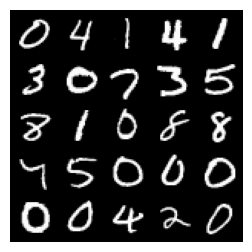

In [8]:
# DDPM samples 1000 denoising steps
C, H, W = config.data.num_channels, config.data.image_size, config.data.image_size
sampling_shape = (config.sampling.generated_batch, C, H, W)

with torch.no_grad():
    uncond_samples = sampling.sampling_fn(config, diffusion, model, sampling_shape, rescaling_inv)
    uncond_samples = torch.clip(uncond_samples * 255, 0, 255).int()

visualize_batch(uncond_samples[:25].cpu(), nrow=5, figsize=(3,5))

100%|██████████| 10/10 [00:00<00:00, 39.51it/s]


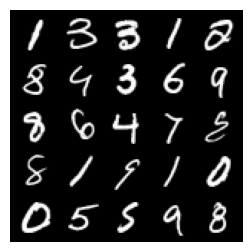

In [9]:
# DDIM samples with n_steps 

n_steps = 10
sampler_name="ddim"
x0 = diffusion.prior_sampling(sampling_shape).to(config.device) 
sampling_fn = sampling.get_fast_sampler(config, diffusion, model, rescaling_inv, sampler_name)
seq, seq_next = sampling.get_time_sequence(n_steps, diffusion.T, skip_type="uniform", late_t=None)
uncond_samples_ddim = sampling_fn(x0, seq, seq_next)
visualize_batch(uncond_samples_ddim[:25].cpu().clip(0,1), nrow=5, figsize=(3,5))